<a href="https://colab.research.google.com/github/kdemertzis/LNexamples/blob/main/DF_autokeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install torchdiffeq


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn
beta = (wn2*Mn+kf*Nn)/Mn

# Define the initial state of the system
qi_init = torch.tensor([0.0, 0.0], requires_grad=True)

# Define the function that describes the dynamics of the system
def damped_vibration(qi, t):
    q1, q2 = qi
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.tensor([dq1dt, dq2dt])

# Define the time steps for the simulation
t = torch.linspace(0, 8.0, 801)

# Solve the differential equation using automatic differentiation
q = torch.odeint(damped_vibration, qi_init, t)
q1 = q[:, 0]

# Train-test split the data
A1mat = np.arange(0, 8.01, 0.01)
A2mat = X1L2*q1*100
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)

# Convert the training and testing data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network model
class Net(torch.nn.Module):
  def init(self):
      super(Net, self).init()
      self.fc1 = torch.nn.Linear(1, 64)
      self.fc2 = torch.nn.Linear(64, 64)
      self.fc3 = torch.nn.Linear(64, 1)

  def forward(self, x):
      x = torch.nn.functional.relu(self.fc1(x))
      x = torch.nn.functional.relu(self.fc2(x))
      x = self.fc3(x)
      return x

# Instantiate the neural network model and define the loss function
model = Net()
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(1000):
    # Forward pass
    y_pred = model(X_train)

# Compute the loss
loss = loss_fn(y_pred, y_train)

# Backward pass and optimization step
optimizer.zero_grad()
loss.backward()
optimizer.step()

# Print the loss every 100 epochs
if epoch % 100 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Compute the loss
loss = loss_fn(y_pred, y_train)

# Backward pass and optimization step
optimizer.zero_grad()
loss.backward()
optimizer.step()

# Print the loss every 100 epochs
if epoch % 100 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

#Evaluate the model on the testing data
with torch.no_grad():
    y_pred = model(X_test)
    mse_test = mean_squared_error(y_test.numpy(), y_pred.numpy())
    mae = mean_absolute_error(y_test.numpy(), y_pred.numpy())
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y_test.numpy(), y_pred.numpy())

#Print the results
print('\nNeural Network Performance Metrics:')
print('Test Set Mean Squared Error:', mse_test)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2)

AttributeError: ignored

In [3]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from torchdiffeq import odeint

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn
beta = (wn2*Mn+kf*Nn)/Mn

# Define the initial state of the system
qi_init = torch.tensor([0.0, 0.0], requires_grad=True)

# Define the function that describes the dynamics of the system
def damped_vibration(t, qi):
    q1, q2 = qi
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.tensor([dq1dt, dq2dt])

# Define the time steps for the simulation
t = torch.linspace(0, 8.0, 801)

# Solve the differential equation using automatic differentiation
q = odeint(damped_vibration, qi_init, t)
q1 = q[:, 0]

# Train-test split the data
A1mat = np.arange(0, 8.01, 0.01)
A2mat = X1L2*q1*100
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)


# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the neural network model and define the loss function
model = Net()
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(1000):
    # Forward pass
    y_pred = model(X_train)

    # Compute the loss
    loss = loss_fn(y_pred, y_train)

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate the model on the testing data
with torch.no_grad():
    y_pred = model(X_test)
    mse_test = mean_squared_error(y_test.numpy(), y_pred.numpy())
    mae = mean_absolute_error(y_test.numpy(), y_pred.numpy())
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y_test.numpy(), y_pred.numpy())

# Print the results
print('\nNeural Network Performance Metrics:')
print('Test Set Mean Squared Error:', mse_test)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2)


<ipython-input-3-0fc5fc4418a1>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-3-0fc5fc4418a1>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([680])) that is different to the input size (torch.Size([680, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.4976
Epoch 100, Loss: 0.2600
Epoch 200, Loss: 0.2600
Epoch 300, Loss: 0.2600
Epoch 400, Loss: 0.2600
Epoch 500, Loss: 0.2600
Epoch 600, Loss: 0.2600
Epoch 700, Loss: 0.2600
Epoch 800, Loss: 0.2600
Epoch 900, Loss: 0.2600

Neural Network Performance Metrics:
Test Set Mean Squared Error: 0.2420308
Mean Absolute Error: 0.40089253
Root Mean Squared Error: 0.49196625
Coefficient of Determination (R^2): -0.00013233900517706232


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torchdiffeq

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn
beta = (wn2*Mn+kf*Nn)/Mn
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

def damped_vibration(t, y):
    q1, q2 = y[0], y[1]
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.stack([dq1dt, dq2dt])

# Define the initial state of the system as a PyTorch tensor with the requires_grad flag
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

# Define the time points at which to evaluate the solution
t = torch.linspace(0.0, 8.0, 801)

# Solve the differential equation using automatic differentiation
q = torchdiffeq.odeint(damped_vibration, q0, t)

# Extract the first component of the solution as the predicted output
q1 = q[:, 0]

# Train-test split the data
A1mat = np.arange(0, 8.01, 0.01)
A2mat = X1L2*q1.detach().numpy()*100
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)

# Define the neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the neural network model and define the loss function and optimizer
net = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Train the neural network
for epoch in range(1000):
    # Convert the training data to PyTorch tensors
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train).float()

    # Reset the gradients
    optimizer.zero_grad()

    # Forward pass through the neural network
    outputs = net(inputs)

    # Compute the loss function
    loss = criterion(outputs, labels)

    # Compute the gradients
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

# Make predictions on the test set using the trained neural network
inputs = torch.from_numpy(X_test).float()
y_pred = net(inputs).detach().numpy()

# Calculate mean absolute error (MAE), root mean squared error (RMSE), and coefficient of determination (R^2)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print('\nNeural Network Predictions:')
results_df = pd.DataFrame({'Time (sec)': X_test.reshape(-1),
                           'Displacement (cm) - Actual': y_test,
                           'Displacement (cm) - Predicted': y_pred.reshape(-1)})
print(results_df.to_string(index=False))

print('\nNeural Network Performance Metrics:')
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2)


Epoch: 0 Loss: 3.177027702331543
Epoch: 100 Loss: 0.2689160704612732
Epoch: 200 Loss: 0.2641291916370392
Epoch: 300 Loss: 0.26273518800735474
Epoch: 400 Loss: 0.261821448802948
Epoch: 500 Loss: 0.2612089514732361
Epoch: 600 Loss: 0.26079899072647095
Epoch: 700 Loss: 0.26051774621009827
Epoch: 800 Loss: 0.2603263556957245
Epoch: 900 Loss: 0.2601965367794037

Neural Network Predictions:
 Time (sec)  Displacement (cm) - Actual  Displacement (cm) - Predicted
       6.97                   -0.171791                      -0.011568
       6.68                   -0.251845                      -0.009747
       0.63                    0.040572                      -0.009258
       5.34                   -0.792576                      -0.001334
       0.66                    0.046353                      -0.009475
       6.22                   -0.452861                      -0.006859
       3.46                    0.469504                       0.010469
       4.90                   -0.744416     

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torchdiffeq
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define the parameters of the system
m = 1
k = 1
beta = 0.1

# Define the initial conditions of the system
q0 = [1, 0]

# Define the forcing function
Pn = 1
c = 1

# Define the differential equation for the damped vibration system
def damped_vibration(t, y):
    q1, q2 = y[0], y[1] if len(y) > 1 else 0
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.stack([dq1dt, dq2dt])

# Define the initial state of the system as a PyTorch tensor with the requires_grad flag
q0 = torch.tensor([1., 0.], requires_grad=True, dtype=torch.float32)

# Define the time points for which to solve the differential equation
t = torch.linspace(0, 20, 1000)

# Solve the differential equation using automatic differentiation
q = torchdiffeq.odeint(damped_vibration, q0, t)

# Extract the first component of the solution as the predicted output
y_pred = q[:, 0]

# Concatenate the interpolated data with the original
t_all = torch.cat((t, t_new))
y_all = torch.cat((y_pred, y_new))

# Convert the data to NumPy arrays
t_all = t_all.detach().numpy()
y_all = y_all.detach().numpy()

# Define the neural network model
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the neural network
X_train, X_test, y_train, y_test = train_test_split(t_all, y_all, test_size=0.15, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

net = Net1()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(1000):
    inputs = torch.autograd.Variable(torch.Tensor(X_train))
    targets = torch.autograd.Variable(torch.Tensor(y_train))

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))


# Test the neural network
X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)
y_test = torch.tensor(y_test, requires_grad=True, dtype=torch.float32)
y_pred = net(X_test)
r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
print(f"Coefficient of Determination (R^2): {r2}")


NameError: ignored

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torchdiffeq

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn
beta = (wn2*Mn+kf*Nn)/Mn
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

def damped_vibration(t, y):
    q1, q2 = y[0], y[1]
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.stack([dq1dt, dq2dt])

# Define the initial state of the system as a PyTorch tensor with the requires_grad flag
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

# Define the time points at which to evaluate the solution
t = torch.linspace(0.0, 16.0, 1601)  # Change the range and step size to increase the dataset size


# Solve the differential equation using automatic differentiation
q = torchdiffeq.odeint(damped_vibration, q0, t)

# Extract the first component of the solution as the predicted output
q1 = q[:, 0]

A1mat = np.linspace(0, 16.0, 1601)
A2mat = X1L2*q1.detach().numpy()*100
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)




# Define the neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the neural network model and define the loss function and optimizer
net = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Train the neural network
for epoch in range(1000):
    # Convert the training data to PyTorch tensors
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train).float()

    # Reset the gradients
    optimizer.zero_grad()

    # Forward pass through the neural network
    outputs = net(inputs)

    # Compute the loss function
    loss = criterion(outputs, labels)

    # Compute the gradients
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print('Epoch:', epoch, 'Loss:', loss.item())

from sklearn.model_selection import ParameterGrid

param_grid = {
    'num_hidden_layers': [1, 2, 3],
    'hidden_layer_size': [10, 20, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [500, 1000, 2000],
}

# Define the neural network model with variable hidden layers and hidden layer size
class Net(torch.nn.Module):
    def __init__(self, num_hidden_layers, hidden_layer_size):
        super(Net, self).__init__()
        self.input_layer = torch.nn.Linear(1, hidden_layer_size)
        self.hidden_layers = torch.nn.ModuleList([
            torch.nn.Linear(hidden_layer_size, hidden_layer_size) for _ in range(num_hidden_layers - 1)
        ])
        self.output_layer = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.nn.functional.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

best_net = None
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    net = Net(params['num_hidden_layers'], params['hidden_layer_size'])
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=params['learning_rate'])

    # Train the neural network
    for epoch in range(params['num_epochs']):
        inputs = torch.from_numpy(X_train).float()
        labels = torch.from_numpy(y_train).float()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Make predictions on the test set using the trained neural network
    inputs = torch.from_numpy(X_test).float()
    y_pred = net(inputs).detach().numpy()

    # Calculate mean absolute error (MAE), root mean squared error (RMSE), and coefficient of determination (R^2)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Save the best model and parameters
    if mae < best_loss:
        best_net = net
        best_loss = mae
        best_params = params

# Print the best parameters
print('Best Hyperparameters:')
print(best_params)


# Make predictions on the test set using the trained neural network
inputs = torch.from_numpy(X_test).float()
y_pred = net(inputs).detach().numpy()

# Calculate mean absolute error (MAE), root mean squared error (RMSE), and coefficient of determination (R^2)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print('\nNeural Network Predictions:')
results_df = pd.DataFrame({'Time (sec)': X_test.reshape(-1),
                           'Displacement (cm) - Actual': y_test,
                           'Displacement (cm) - Predicted': y_pred.reshape(-1)})
print(results_df.to_string(index=False))

print('\nNeural Network Performance Metrics:')
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1360])) that is different to the input size (torch.Size([1360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 17.146499633789062
Epoch: 100 Loss: 2.000664472579956
Epoch: 200 Loss: 0.2972821295261383
Epoch: 300 Loss: 0.27331313490867615
Epoch: 400 Loss: 0.26331183314323425
Epoch: 500 Loss: 0.25550520420074463
Epoch: 600 Loss: 0.25498852133750916
Epoch: 700 Loss: 0.25491979718208313
Epoch: 800 Loss: 0.25489741563796997
Epoch: 900 Loss: 0.2548879086971283


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1360])) that is different to the input size (torch.Size([1360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1360])) that is different to the input size (torch.Size([1360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1360])) that is different to the input size (torch.Size([1360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo

Best Hyperparameters:
{'hidden_layer_size': 50, 'learning_rate': 0.1, 'num_epochs': 1000, 'num_hidden_layers': 2}

Neural Network Predictions:
 Time (sec)  Displacement (cm) - Actual  Displacement (cm) - Predicted
       5.26                   -0.798767                      -0.020875
       3.54                    0.397477                      -0.022597
       1.68                    0.507583                      -0.022946
       1.35                    0.314036                      -0.022866
       9.37                    0.420930                      -0.019079
      15.45                   -0.247737                      -0.022326
      15.96                   -0.235507                      -0.022900
       2.37                    0.835396                      -0.023127
       4.78                   -0.694977                      -0.021356
       6.50                   -0.321845                      -0.020632
       5.14                   -0.796042                      -0.020995
     

In [41]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00


In [57]:
import numpy as np
import pandas as pd
import autokeras as ak
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn

# Generate the input and output data
A1mat = np.linspace(0, 16.0, 1601)
A2mat = X1L2*np.sin(Pn*c*A1mat)*100

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)

# Define the AutoKeras model
reg = ak.StructuredDataRegressor(max_trials=10)

# Fit the AutoKeras model to the training data
reg.fit(X_train, y_train, verbose=0)

# Generate predictions using the AutoKeras model
y_pred = reg.predict(X_test)

# Calculate mean absolute error (MAE), root mean squared error (RMSE), and coefficient of determination (R^2)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean(np.square(y_test - y_pred)))
r2 = r2_score(y_test, y_pred)

# Print the results
print('\nAutoKeras Predictions:')
results_df = pd.DataFrame({'Time (sec)': X_test.reshape(-1),
                           'Displacement (cm) - Actual': y_test,
                           'Displacement (cm) - Predicted': y_pred.reshape(-1)})
print(results_df.to_string(index=False))

print('\nAutoKeras Performance Metrics:')
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('Coefficient of Determination (R^2):', r2)


8/8 [==============================] - 0s 2ms/step

AutoKeras Predictions:
 Time (sec)  Displacement (cm) - Actual  Displacement (cm) - Predicted
       5.26                  -83.580736                     -96.674835
       3.54                   35.347484                      -7.494800
       1.68                   96.858316                      52.445015
       1.35                   87.249601                      55.768921
       9.37                   88.006330                      86.674728
      15.45                  -41.865974                     -86.000092
      15.96                   -3.141076                     -97.286972
       2.37                   95.807290                      45.231464
       4.78                  -57.500525                     -76.688538
       6.50                  -92.387953                     -87.077583
       5.14                  -78.043041                     -94.219566
      15.87                  -10.192446                     -95.295166
  

Trial 10 Complete [00h 00m 05s]
val_loss: 0.1401214450597763

Best val_loss So Far: 0.003429385367780924
Total elapsed time: 00h 00m 53s
Epoch 1/10
43/43 [==============================] - 2s 5ms/step - loss: 0.2993 - mean_squared_error: 0.2993
Epoch 2/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 3/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 4/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 5/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 6/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 7/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 8/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0063 - mean_squared_error: 0.0063

8/8 [==============================] - 0s 2ms/step
MAE: 0.59720784
RMSE: 0.7342295
R2 Score: 0.9529030795735665
8/8 [==============================] - 0s 2ms/step


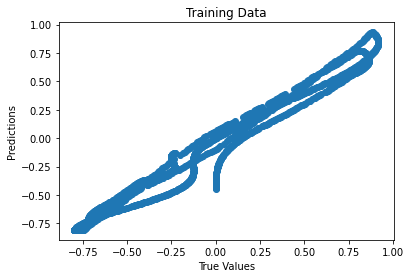

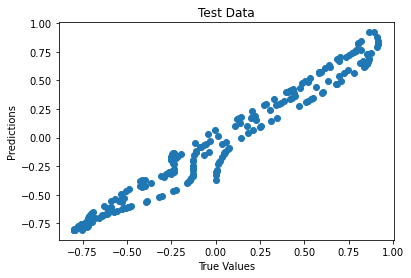

In [55]:
import numpy as np
import tensorflow as tf
import pandas as pd
import torch
import torchdiffeq
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from autokeras import StructuredDataRegressor
import matplotlib.pyplot as plt

# Define the input parameters
E = 29000000.0 # Modulus of elasticity (kN/m2)
I = 0.00423 # Moment of inertia of the cross-section (m4)
Area = 0.69 # Area of the cross-section (m2)
L = 4.0 # Length of beam (m)
p = 27395.515 # Mass/volume unit (kg/m3)
kf = 1500.0 # Modulus of the subgrafe reaction (kN/m2)
Pe = 500.0 # External moving load (kN)
c = 1.00 # Velocity of the external load (m/sec)

# A. STEP: Solution of eigenvalue problem -> Calculation of eigenfrequencies and
# eigenvectors: EI*(d4X/dx4)+(kf-wn2*p*Area)*X=0
# First eigenfrequency
n = 1
wn = np.sqrt((1/(p*Area))*((((n**4)*(np.pi**4)*E*I)/(L**4))+kf))
# First eigenvector - value in the middle of the beam : x=L/2
Pn = ((wn**2*p*Area-kf)/(E*I))**(1/4)
X1L2 = np.sin(Pn*(L/2))

# B. STEP: Calculation of the generalized parameters qi(t)
# (dqi2/dt2)+((wn2*Mn+kf*Nn)/Mn)*qi=(Pe/Mn)*sin(Pn*c*t)
wn2 = wn**2
Nn = (L/2)-(np.sin(2*Pn*L)/(4*Pn))
Mn = p*Area*Nn
k = Pe/Mn
beta = (wn2*Mn+kf*Nn)/Mn
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

def damped_vibration(t, y):
    q1, q2 = y[0], y[1]
    dq1dt = q2
    dq2dt = k*torch.sin(Pn*c*t) - beta*q1
    return torch.stack([dq1dt, dq2dt])

# Define the initial state of the system as a PyTorch tensor with the requires_grad flag
q0 = torch.tensor([0.0, 0.0], requires_grad=True)

# Define the time points at which to evaluate the solution
t = torch.linspace(0.0, 16.0, 1601)

# Solve the differential equation using automatic differentiation
q = torchdiffeq.odeint(damped_vibration, q0, t)

# Extract the first component of the solution as the predicted output
q1 = q[:, 0]

A1mat = np.linspace(0, 16.0, 1601)
A2mat = X1L2*q1.detach().numpy()*100
X_train, X_test, y_train, y_test = train_test_split(A1mat.reshape(-1, 1), A2mat.reshape(-1), test_size=0.15, random_state=42)

# Define the AutoKeras model
reg = ak.StructuredDataRegressor(max_trials=10, overwrite=True)

# Search for the best model architecture
reg.fit(X_train, y_train, epochs=10)

# Evaluate the AutoKeras model on the test data
y_pred = reg.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean(np.square(y_test - y_pred)))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)

# Generate predictions using the AutoKeras model
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Plot the predicted values against the true values for the training data
plt.scatter(y_train, y_pred_train)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Training Data")
plt.show()

# Plot the predicted values against the true values for the test data
plt.scatter(y_test, y_pred_test)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Test Data")
plt.show()

